In [1]:
import sqlite3
import pandas as pd
import numpy as np
import os
import polars as pl

import random
random.seed(42)

import sys

sys.path.append('../')
sys.path.append('../src')
from dotenv import load_dotenv

import plotly.express as px

In [2]:
# Load the environment variables from the .env file
dotenv_path = os.path.join('../', '.env')
load_dotenv(dotenv_path)

True

In [15]:
from functions.env import DB_SCIENCE_PATH

conn = sqlite3.connect(DB_SCIENCE_PATH)
conn_full_db = sqlite3.connect(os.getenv("FULL_DB_PATH"))

columns_to_keep = [
        "re_arabic_world",
        "re_central_europe",
        "re_chinese_world",
        "re_eastern_europe",
        "re_france",
        "re_german_world",
        "re_greek_world",
        "re_indian_world",
        "re_italy",
        "re_japan",
        "re_low_countries",
        "re_nordic_countries",
        "re_persian_world",
        "re_slav_world",
        "re_spain",
        "re_united_kingdom",
    ]


df_occupation = pd.read_sql("SELECT * FROM individual_id_cleaned_occupations", conn)


df_ind_regions = pd.read_sql_query(
        "SELECT * FROM individuals_regions", conn_full_db
    )
df_ind_regions = df_ind_regions.rename(
        columns={"individual_wikidata_id": "wikidata_id"}
    )


df_indi = pd.merge(df_occupation, df_ind_regions, on = 'wikidata_id', how = 'left')
df_indi = df_indi[['wikidata_id', 'region_code']].drop_duplicates()

Get the % of occupation for each country by gicing the same weight to all regions

In [30]:
data_all = pd.read_sql_query(
        "SELECT * FROM temporal_data_clean", conn
    )
df_regions = pd.read_sql_query(
        "SELECT * FROM regions", conn_full_db
    )

data_all = pd.merge(data_all,df_regions, on = 'region_code')
data_all = data_all[data_all['region_code'].isin(columns_to_keep)]
data_all = data_all.drop('region_code', axis=1)
data_all = data_all.rename(columns = {'region_name':'region_code'})

In [32]:
data_norm = data_all.groupby(['region_code', 'century', 'interest'])['wikidata_id'].count().reset_index()
data_norm.groupby('interest')['wikidata_id'].sum()
data_norm = data_norm[data_norm['wikidata_id']>=0]

count_all =  data_norm.groupby(['region_code', 'century'])['wikidata_id'].sum().rename('count_all').reset_index()
data_norm = pd.merge(data_norm, count_all, on = ['region_code', 'century'])
data_norm['percent'] = data_norm['wikidata_id']/data_norm['count_all']
data_norm.groupby('interest')['percent'].mean()

interest
Abstract Domain    0.629706
Human Domain       0.353788
Natural Domain     0.241273
Name: percent, dtype: float64

In [33]:
set(data_norm.region_code)

{'Arabic world',
 'Central Europe',
 'Chinese world',
 'Eastern Europe',
 'France',
 'German world',
 'Greek World',
 'Indian world',
 'Italy',
 'Japan',
 'Low countries',
 'Nordic countries',
 'Persian world',
 'Slav world',
 'Spain',
 'United Kingdom'}

In [34]:
data_all[['wikidata_id', 'interest']].drop_duplicates().interest.value_counts()

Natural Domain     10632
Abstract Domain     6607
Human Domain        6583
Name: interest, dtype: int64

In [43]:
final_pie = []
for region in data_norm['region_code'].unique():
    df_test = data_norm[data_norm['region_code']==region]
    interest_century_totals = df_test[['interest', 'century', 'percent']]
    interest_totals = interest_century_totals.groupby('interest')['percent'].mean().reset_index()
    interest_totals['percent'] = interest_totals['percent']/interest_totals['percent'].sum()
    interest_totals['region_code'] = region
    final_pie.append(interest_totals)
    
df_final_pie = pd.concat([x for x in final_pie])
#df_final_pie = df_final_pie[df_final_pie['region_code'].isin(columns_to_keep)]

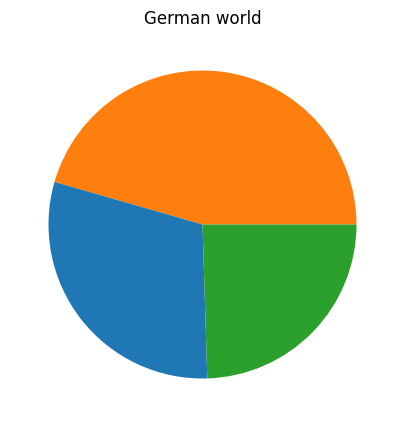

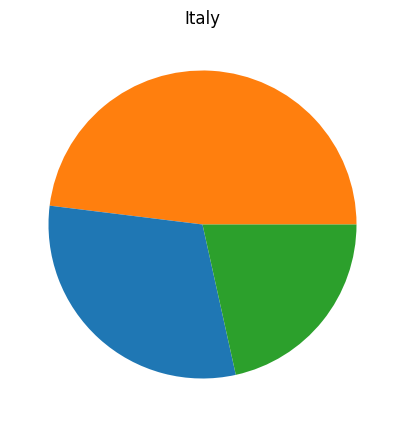

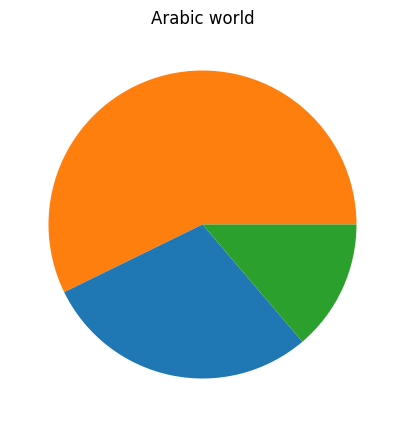

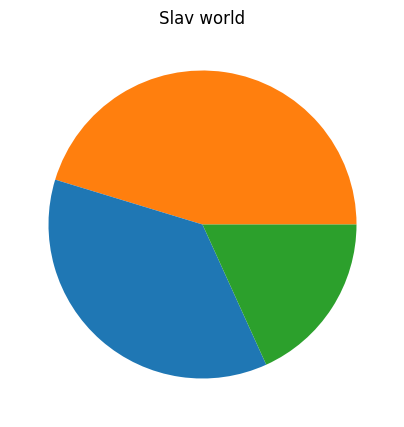

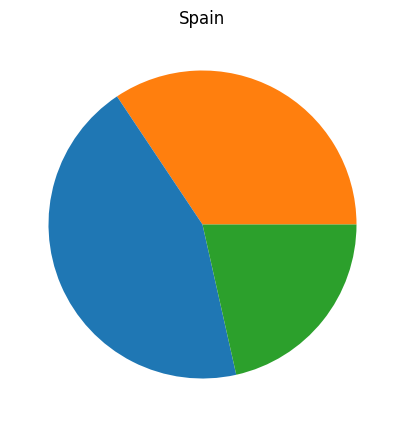

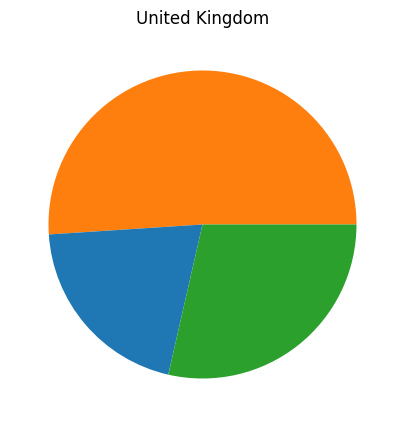

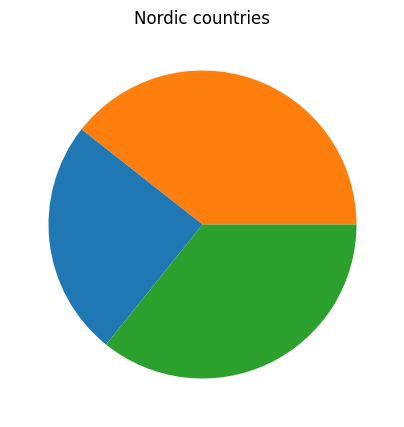

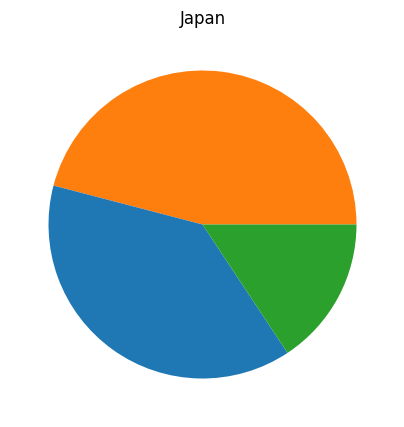

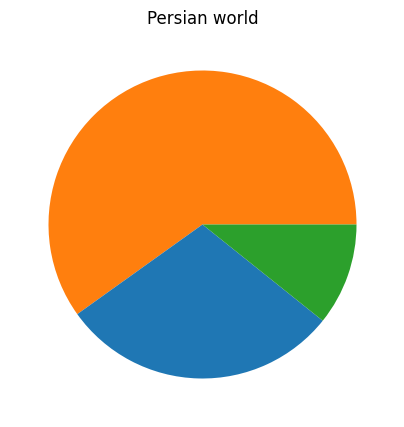

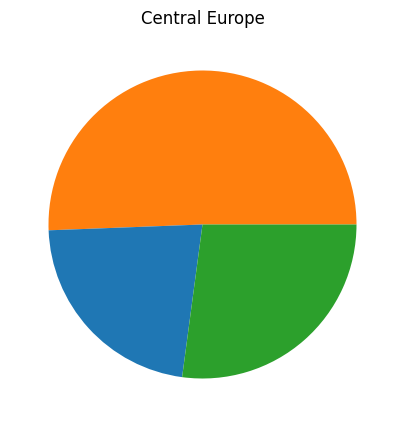

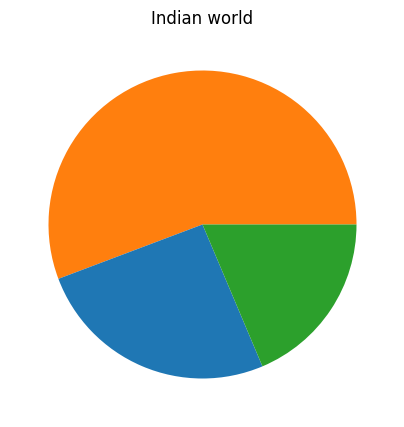

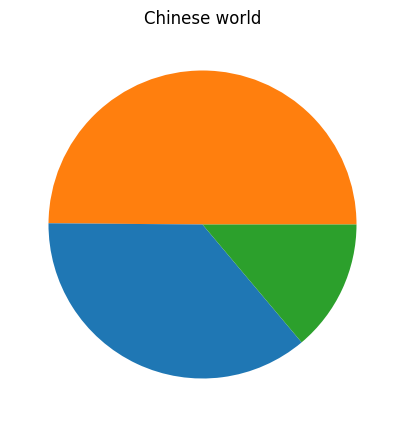

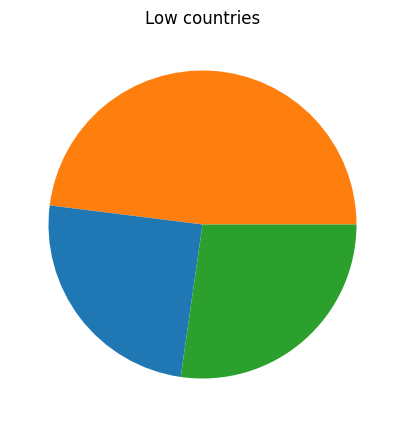

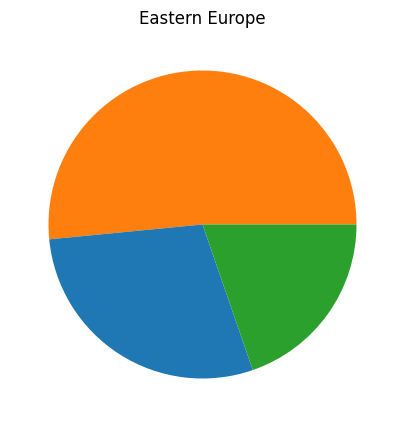

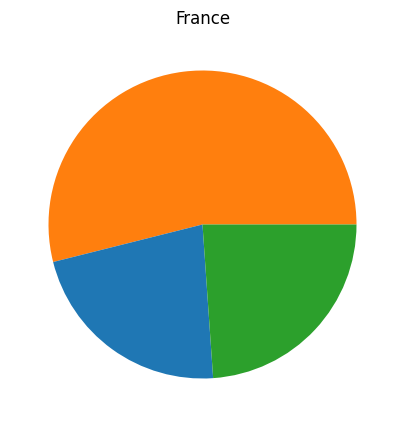

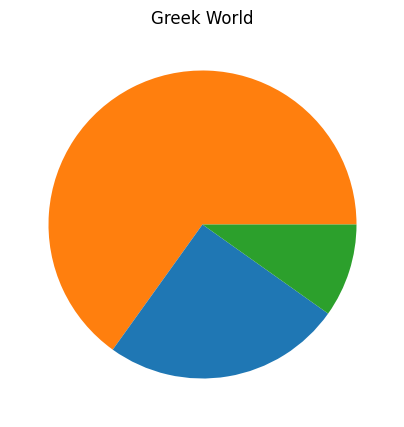

In [53]:
import matplotlib.pyplot as plt

# Define a dictionary that maps interests to colors
interest_colors = {
    'Human Domain': '#1f77b4',
    'Abstract Domain': '#ff7f0e',
    'Natural Domain': '#2ca02c',
    # Add more interests and colors as needed
}

regions = list(set(df_final_pie.region_code))

for region in regions:
    test = df_final_pie[df_final_pie['region_code'] == region]
    test = test.set_index('interest')
    
    # Assign colors to interests based on the dictionary
    colors = [interest_colors.get(interest, 'gray') for interest in test.index]
    
    plot = test.plot.pie(y='percent', 
                         figsize=(5, 5), 
                         title=region, 
                         colors=colors, 
                         legend=False, 
                         labels = None)
                        #autopct='%1.1f%%')
    plot.set_ylabel('')
    plot.figure.savefig(f"pie_figures/{region}.png", transparent=True)

plt.show()

In [188]:
df = data_all[['wikidata_id', 'region_code', 'interest']].drop_duplicates()
df = df.groupby(['region_code', 'interest'])['wikidata_id'].count().reset_index()

df_count = df.groupby('region_code')['wikidata_id'].sum().reset_index()
df_count.columns = ['region_code', 'total']
final_df = pd.merge(df, df_count, on = 'region_code')
final_df['percent'] = final_df['wikidata_id']/final_df['total']
final_df = final_df[final_df['region_code'].isin(columns_to_keep)]

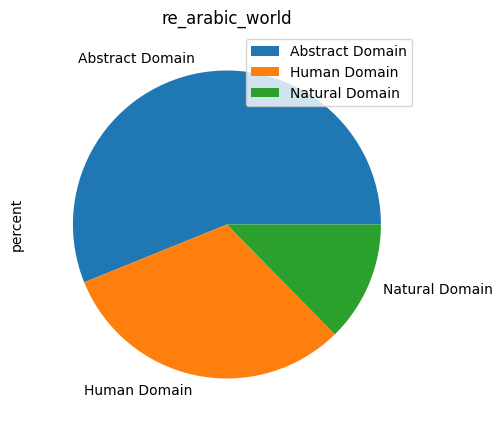

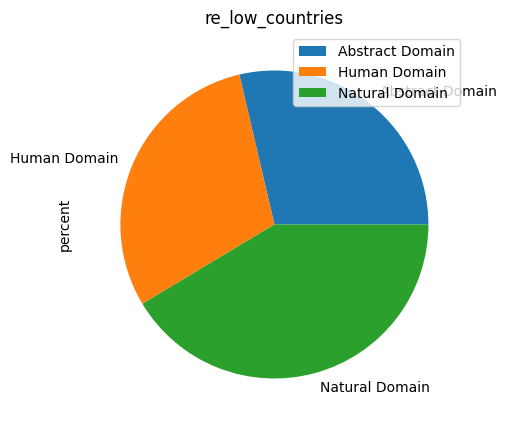

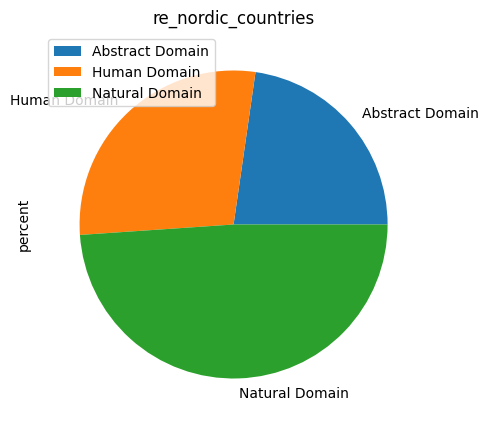

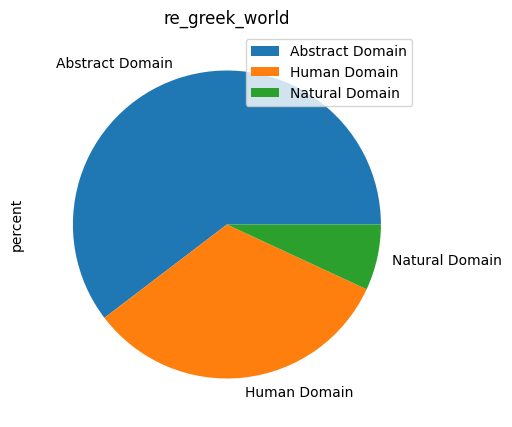

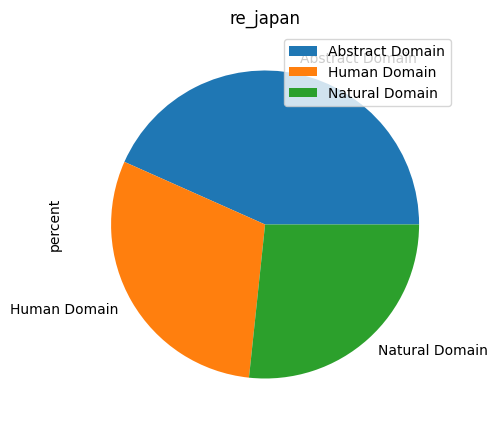

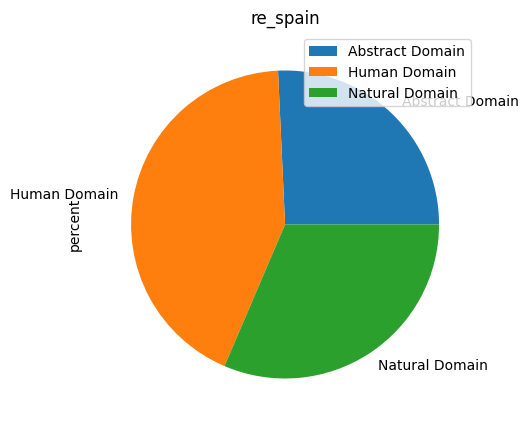

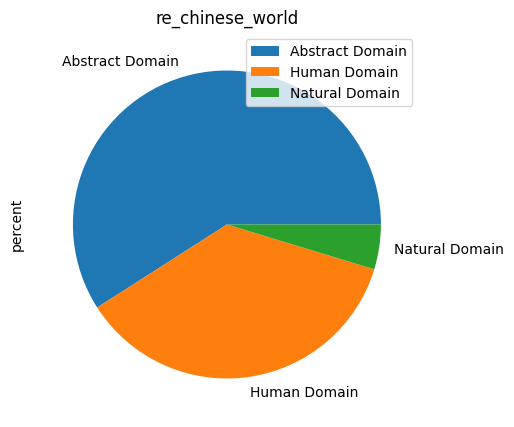

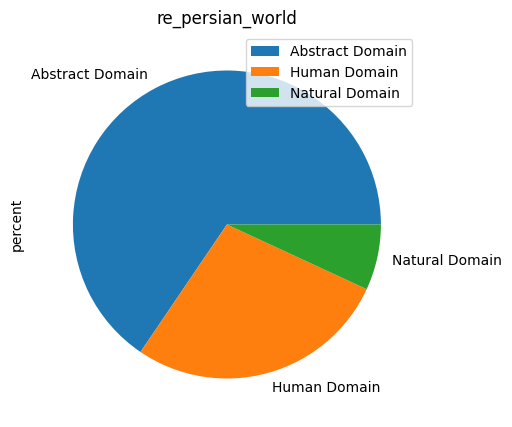

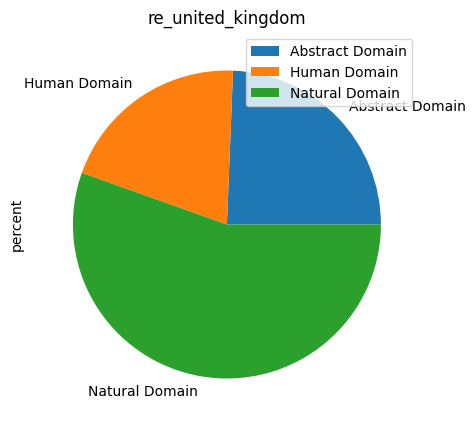

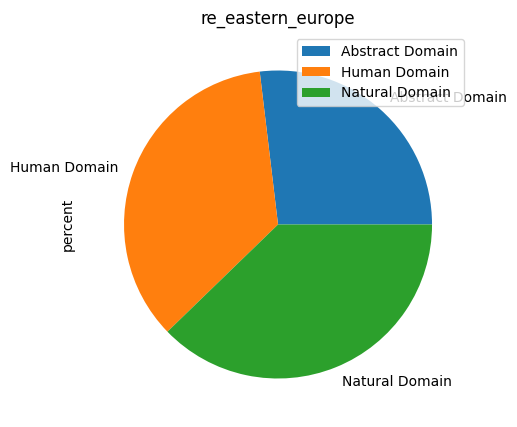

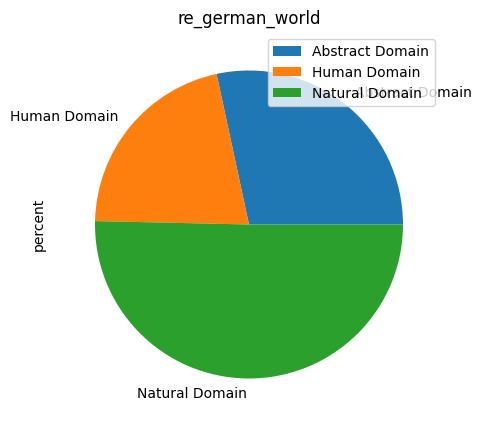

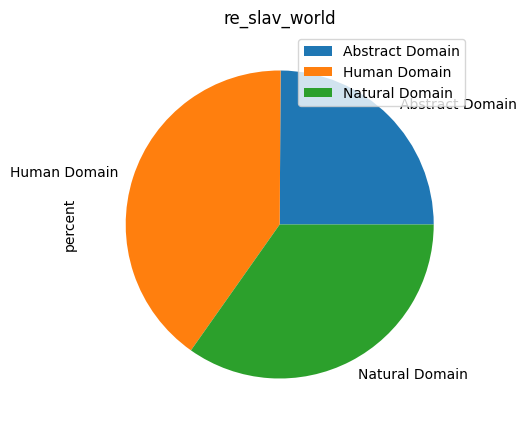

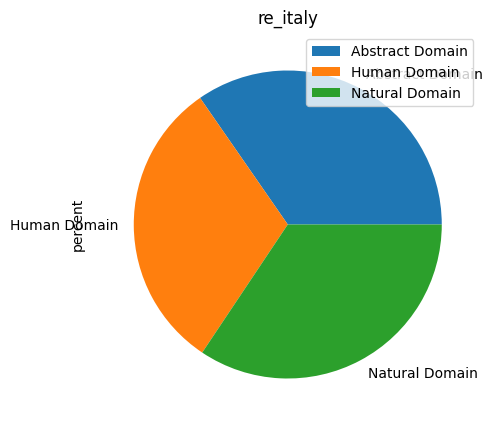

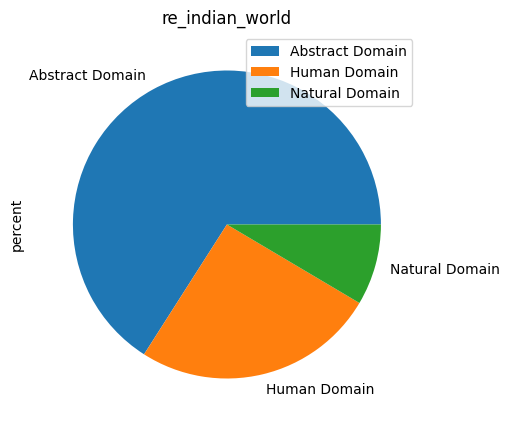

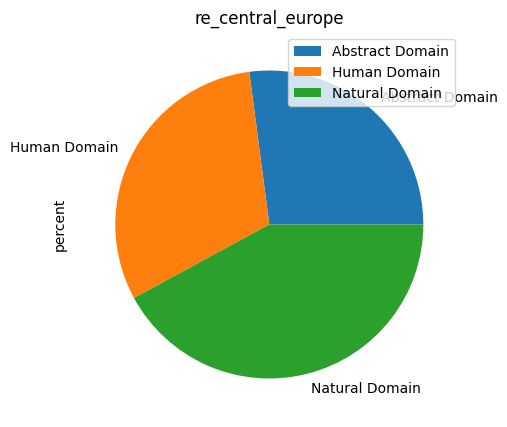

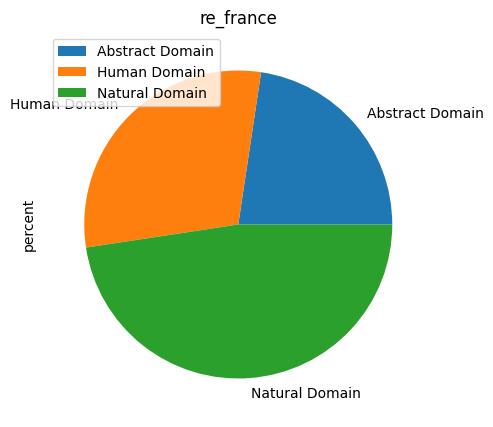

In [29]:
import matplotlib.pyplot as plt
from itertools import cycle

# Define a list of nice colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

regions = list(set(final_df.region_code))
color_cycle = cycle(colors)

for region in regions:
    test = final_df[final_df['region_code'] == region]
    test = test.set_index('interest')
    plot = test.plot.pie(y='percent', figsize=(5, 5), title=region, colors=[next(color_cycle) for _ in range(len(test))])
    plot.figure.savefig(f"pie_figures/{region}.png")

plt.show()


#### Geopandas

In [23]:
import pandas as pd

data = pd.DataFrame({
    'name': ['Fiji', 'Tanzania', 'Canada'],
    'Latitude': [44, 33, 11],  # Replace with actual coordinates
    'Longitude': [123, 34, 160],  # Replace with actual coordinates
    'Value1': [30, 50, 20],  # Values for the first category
    'Value2': [40, 20, 10],  # Values for the second category
    # Add more categories as needed
})

In [24]:
import geopandas as gpd
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_63770/2162896047.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [25]:
merged_data = world.merge(data, on='name')

In [26]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
world.boundary.plot(ax=ax, linewidth=1, color='black')  # Plot country boundaries


# Plot pie charts on the main regions
for x, y, region, val1, val2 in zip(merged_data['Longitude'], merged_data['Latitude'],
                                    merged_data['name'], merged_data['Value1'], merged_data['Value2']):
    ax.annotate(region, xy=(x, y), fontsize=10, ha='center', va='center')
    ax.pie([val1, val2], center=(x, y), radius=0.2, startangle=90, colors=['#ff9999', '#66b3ff'],
           autopct='%1.1f%%', pctdistance=0.85)
    
plt.show()